# DSCI 100 Final Project
## Group 33

### Introduction

#### Background information:
A Computer Science research team at UBC led by Frank Wood set up a Minecraft server, recording player's actions to explore how people play video games. We wanted to figure out which player characteristics or behaviours could be used to predict their subscription status to the game-related newsletter.

#### Question:
Can player’s hours played, age  and experience level predict whether a player is subscribed to the game-related newsletter?

#### Data Set
The data set we used to answer this question was the Player’s Dataset (players.csv). The dataset contains 196 observations and 7 variables, including player's experience, age, gender, email, name, subscription status and hours played. However the variables of interest for answering this question are age, experience and hours played.

### Methods & Results

The first step is to load the data,

In [2]:
library(tidyverse)
library(repr)
library(tidymodels) # Load the packages
player_data<-read_csv("data/players.csv") # loads data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


And then we need to fill out the blank in the dataset, to make it tidy.

In [4]:
player_data<- select(player_data,subscribe,played_hours,Age,experience) # select needed variable
player_data$Age[is.na(player_data$Age)] <- median(player_data$Age, na.rm = TRUE) # add median for NA age data
player_data<-mutate(player_data,experience = as_factor(experience),subscribe = as_factor(subscribe))

#### performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 

In [5]:
head(player_data,5) 
summary(player_data) #Generate summary

subscribe,played_hours,Age,experience
<lgl>,<dbl>,<dbl>,<chr>
TRUE,30.3,9,Pro
TRUE,3.8,17,Veteran
FALSE,0.0,17,Veteran
TRUE,0.7,21,Amateur
TRUE,0.1,21,Regular


 subscribe        played_hours          Age         experience       
 Mode :logical   Min.   :  0.000   Min.   : 8.00   Length:196        
 FALSE:52        1st Qu.:  0.000   1st Qu.:17.00   Class :character  
 TRUE :144       Median :  0.100   Median :19.00   Mode  :character  
                 Mean   :  5.846   Mean   :20.51                     
                 3rd Qu.:  0.600   3rd Qu.:22.00                     
                 Max.   :223.100   Max.   :50.00                     

**Table: Summary of numeric varibles**
| Variable          | Class      | Min     | 1st Quartile | Median | Mean  | 3rd Quartile | Max    | NA's |
|------------------|-----------|--------|--------|--------|--------|--------|--------|------|
| **played_hours** | double    | 0.000  | 0.000  | 0.100  | 5.846  | 0.600  | 223.100 | 0    |
| **Age**        | double     | 8.00   | 17.00  | 19.00  | 20.52  | 22.00  | 50.00  | 2    |

Then we want to do the data visualization to show the relation between subscribe and other variables.

The first chart is showing Proportion of Subscription Rate by Played Hours Range

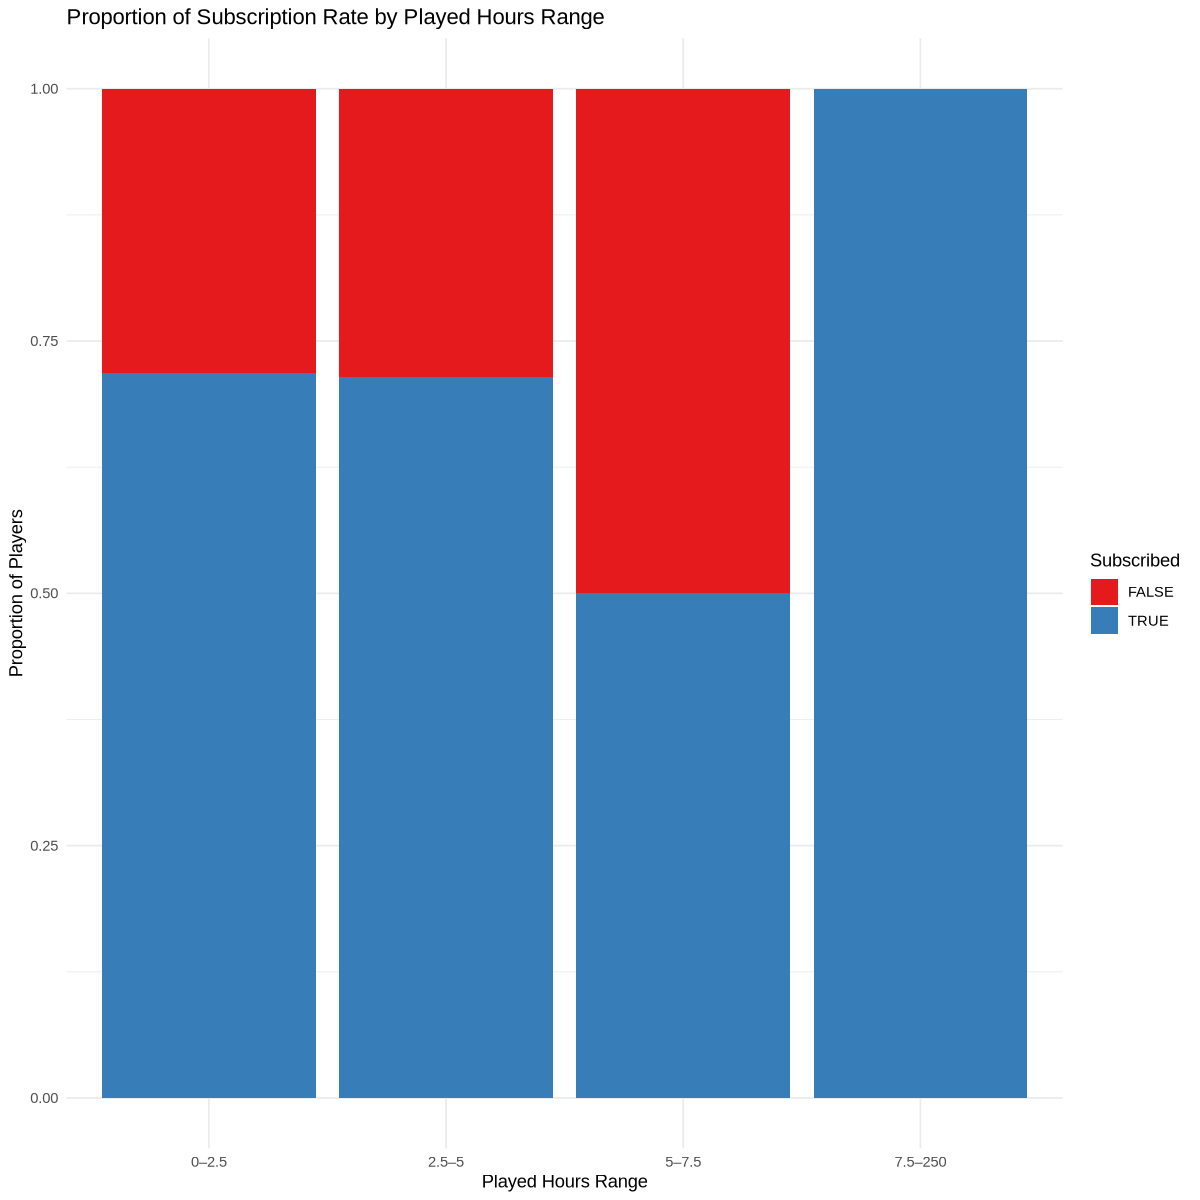

In [28]:
options(repr.plot.width = 10, repr.plot.height = 10)
#First create played hour range category
players <- player_data|>
  mutate(hour_group = case_when(
    played_hours >= 0 & played_hours < 2.5 ~ "0–2.5",
    played_hours >= 2.5 & played_hours <= 5 ~ "2.5–5",
    played_hours >= 5 & played_hours < 7.5 ~ "5–7.5",
    played_hours >= 7.5 & played_hours < 250 ~ "7.5–250",
    
    TRUE ~ NA_character_
  ))

#Turn "subscribe" into a factor
players$subscribe <- as.factor(players$subscribe)

#Bar chart: subscription status by hour range
ggplot(players, aes(x = hour_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Proportion of Subscription Rate by Played Hours Range",
    x = "Played Hours Range",
    y = "Proportion of Players",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

The second chart is showing Proportion of Subscription Rate by Age Range

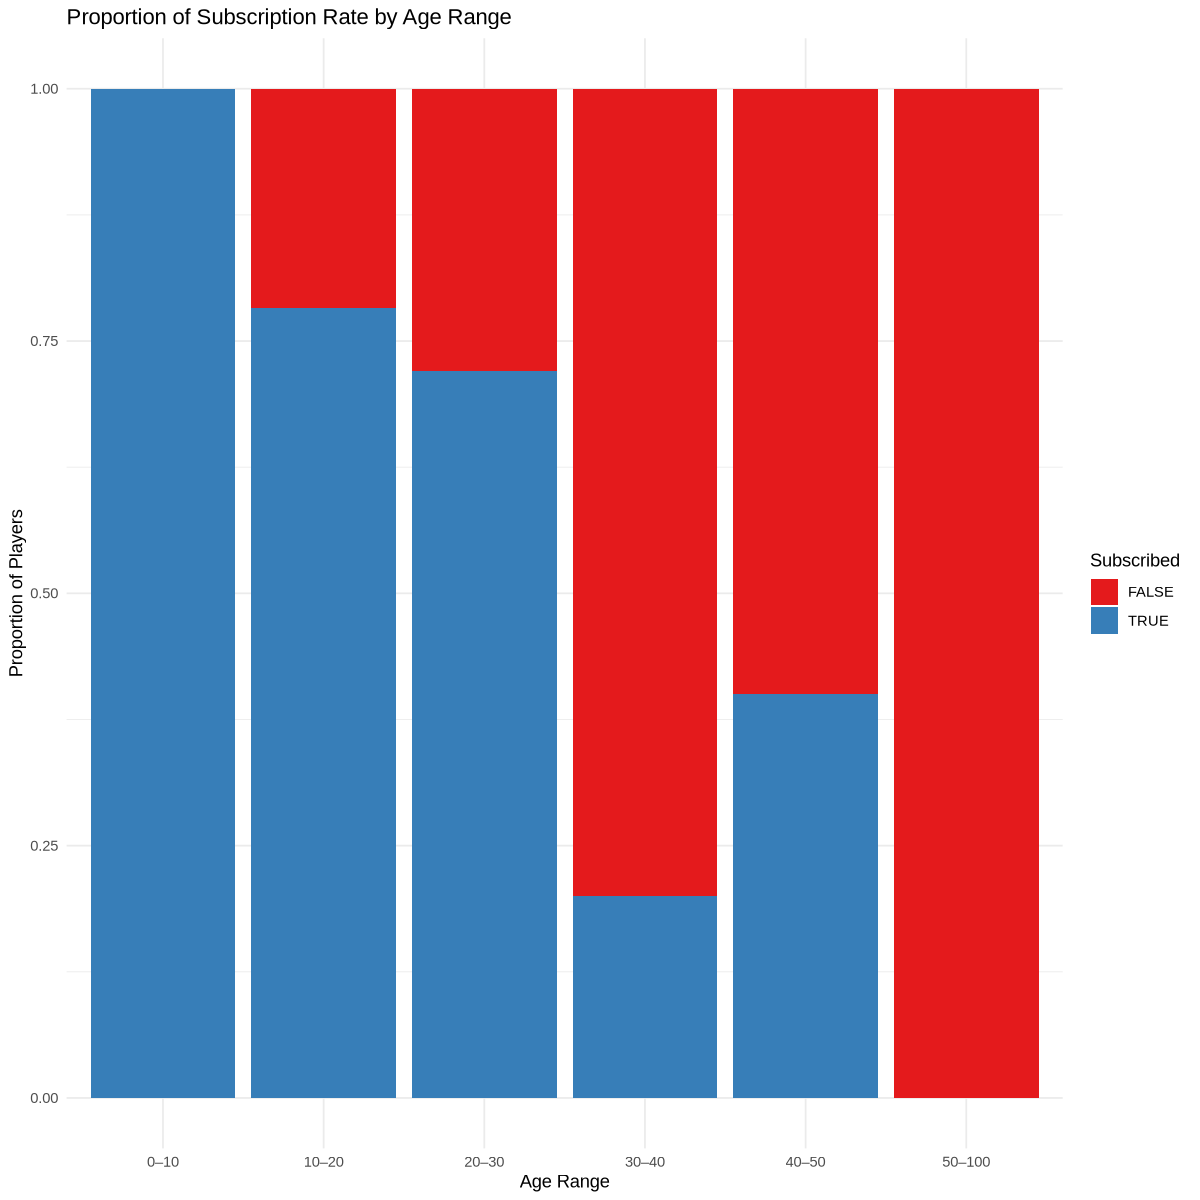

In [29]:
options(repr.plot.width = 10, repr.plot.height = 10)
#First create age range category
players1 <- player_data|>
  mutate(age_group = case_when(
    Age >= 0 & Age < 10 ~ "0–10",
    Age >= 10 & Age <= 20 ~ "10–20",
    Age >= 20 & Age < 30 ~ "20–30",
    Age >= 30 & Age < 40 ~ "30–40",
    Age >= 40 & Age < 50 ~ "40–50",
    Age >= 50 & Age < 100 ~ "50–100",
      
    
    TRUE ~ NA_character_
  ))
#Turn "subscribe" into a factor
players$subscribe <- as.factor(players$subscribe)

#Bar chart: subscription status by age range
ggplot(players1, aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Proportion of Subscription Rate by Age Range",
    x = "Age Range",
    y = "Proportion of Players",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

The third chart is showing proportion of subscription rate by experience level.

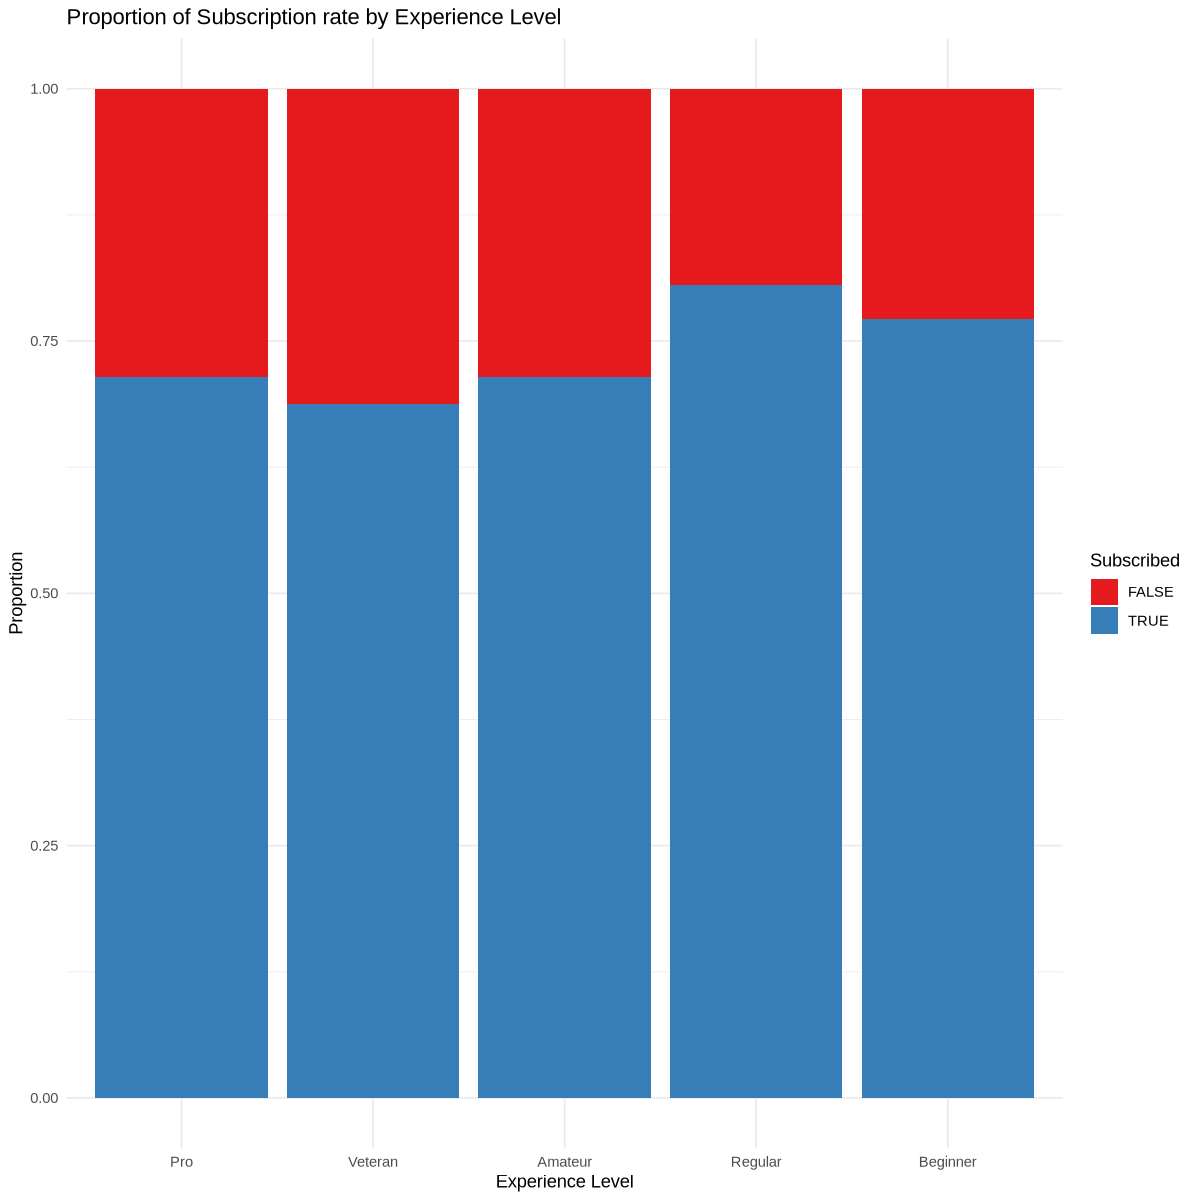

In [30]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Proportion of Subscription rate by Experience Level",
    x = "Experience Level",
    y = "Proportion",
    fill = "Subscribed"
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

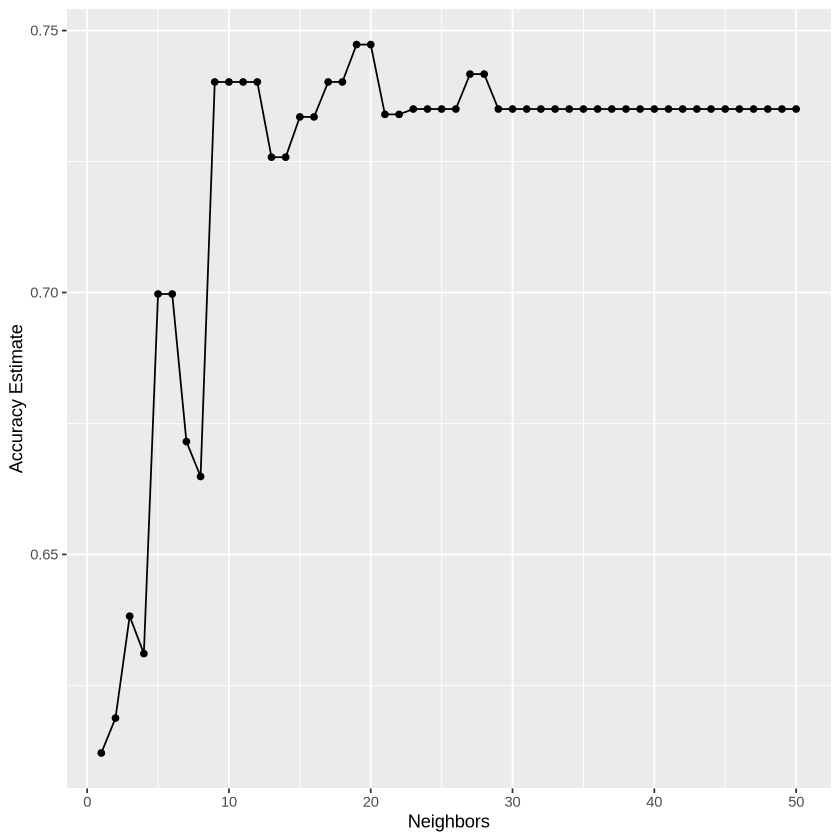

In [26]:
set.seed(1234)

data_split<-initial_split(player_data, prop = 0.75, strata = subscribe)
data_train<- training(data_split)  
data_test<- testing(data_split)

data_recipe <- recipe(subscribe ~. , data = data_train)  |>
   step_center(played_hours:Age)|>
   step_scale(played_hours:Age)

data_vfold <- vfold_cv(data_train, v = 10, strata = subscribe)

knn_tune<-nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")
                      
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = data_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |> 
      filter(.metric=="accuracy")|> # filter out metric type we want
        arrange(desc(mean))

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

In [33]:
best_k_accuracies <- knn_results |> 
      filter(.metric=="accuracy")|> # filter out metric type we want
        arrange(desc(mean))|>
        select(neighbors)|>
        slice(1)|>
        pull()

best_k_accuracies

knn_spec<-nearest_neighbor(weight_func = "rectangular",neighbors = best_k_accuracies) |>
     set_engine("kknn") |>
     set_mode("classification")
player_fit <- workflow() |>
      add_recipe(data_recipe) |>
      add_model(knn_spec) |>#spec using finding of k value
      fit(data = data_train)
player_test_predictions <- predict(player_fit, data_test) |>
      bind_cols(data_test)

player_prediction_accuracy <- player_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)  

confusion_mat <- player_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class) 
confusion_mat

[1] 19

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

### Discussion

### References